In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt

#Order of emotion in one_hot: Anger, Disgust, Fear, Happy, Neutral, Sad
emotions = np.array(['ANG','DIS','FEA','HAP','NEU','SAD'])

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
cd '/content/gdrive/My Drive/Colab Notebooks/Voice_CNN/'

/content/gdrive/My Drive/Colab Notebooks/Voice_CNN


In [5]:
audiolength = np.load('audiolength.npy')
one_hot = np.load('one_hot.npy')
[min_a, max_a,max_length,entry] = np.load('stats.npy')
all_mels_padded = np.load('all_mels_padded.npy')

#Train-test split

In [6]:
split = np.floor(entry*0.9)
Input_Shape = [256,int(max_length),1]

In [7]:
all_mels_padded = np.array(all_mels_padded)
all_mels_padded.min()

0.0

In [8]:
all_mels_padded = all_mels_padded.reshape([-1]+Input_Shape)
mels_train = all_mels_padded[:int(split)]
mels_test = all_mels_padded[int(split):]

In [9]:
mels_train.shape
#mels_test.shape

(6697, 256, 79, 1)

In [10]:
print(mels_train.shape)
print(one_hot[:int(split)].shape)

(6697, 256, 79, 1)
(6697, 6)


#Model 1

In [11]:
from tensorflow.python.ops.math_ops import xdivy
from tensorflow.keras.layers import *


tf.keras.backend.clear_session()

inputs = tf.keras.Input(shape = Input_Shape)
conv_1 = Conv2D(
    filters = 32, kernel_size = (3,3),
    strides = (1,1), padding = 'same',
    activation = 'relu'
)(inputs)
maxpool_1 = MaxPooling2D(
    pool_size=(2, 2),
    strides=(2,2),
    padding = 'valid'
)(conv_1)
dropout_1 = Dropout(0.3)(maxpool_1)
conv_2 = Conv2D(
    filters = 64, kernel_size = (4,4),
    strides = (1,1), padding = 'same',
    activation = 'relu'
)(maxpool_1)
maxpool_2 = MaxPooling2D(
    pool_size=(2, 2),
    strides=(2,2),
    padding = 'valid'
)(conv_2)
dropout_2 = Dropout(0.4)(maxpool_2)
flatten = Flatten()(dropout_2)
dense_1 = Dense(units=500, activation='relu')(flatten)
dropout_4 = Dropout(0.75)(dense_1)
outputs = Dense(units=len(emotions),activation='softmax')(dropout_4)

model = tf.keras.Model(
    inputs = inputs, outputs = outputs,
    name = 'cnn-1'
)

optimizer = tf.keras.optimizers.SGD(lr = 0.01)

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

model.summary()

Model: "cnn-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 79, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 256, 79, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 39, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 39, 64)       32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 19, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 64, 19, 64)        0     

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
dense_2 = Dense(units=250, activation='relu')(dropout_4)from sklearn.utils import class_weight
y_ints = [y.argmax() for y in one_hot]
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(one_hot),y=y_ints)

ValueError: ignored

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

batch_size = 64
epochs = 500


es = EarlyStopping(
    monitor='val_accuracy',
    min_delta = 0,
    patience = 500,
    verbose = 1,
    mode = 'max',
    restore_best_weights = True
)

history = model.fit(mels_train, one_hot[:int(split)], epochs=epochs, batch_size=batch_size, 
                    validation_split=0.3, callbacks=[es])




Epoch 1/500
74/74 [==============================] - 15s 75ms/step - loss: 1.7847 - accuracy: 0.2014 - val_loss: 1.7638 - val_accuracy: 0.2249
Epoch 2/500
74/74 [==============================] - 5s 62ms/step - loss: 1.7687 - accuracy: 0.2185 - val_loss: 1.7532 - val_accuracy: 0.2139
Epoch 3/500
74/74 [==============================] - 5s 62ms/step - loss: 1.7602 - accuracy: 0.2306 - val_loss: 1.7434 - val_accuracy: 0.2318
Epoch 4/500
74/74 [==============================] - 5s 62ms/step - loss: 1.7524 - accuracy: 0.2385 - val_loss: 1.7416 - val_accuracy: 0.2607
Epoch 5/500
74/74 [==============================] - 5s 62ms/step - loss: 1.7456 - accuracy: 0.2430 - val_loss: 1.7307 - val_accuracy: 0.2443
Epoch 6/500
74/74 [==============================] - 5s 62ms/step - loss: 1.7382 - accuracy: 0.2524 - val_loss: 1.7242 - val_accuracy: 0.2920
Epoch 7/500
74/74 [==============================] - 5s 62ms/step - loss: 1.7192 - accuracy: 0.2729 - val_loss: 1.7080 - val_accuracy: 0.3015
Epoch

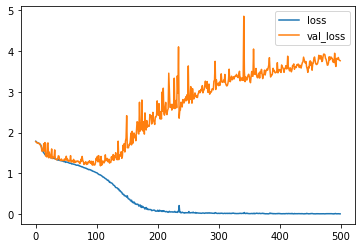

In [12]:
res = pd.DataFrame(history.history)
res[['loss','val_loss']].plot()

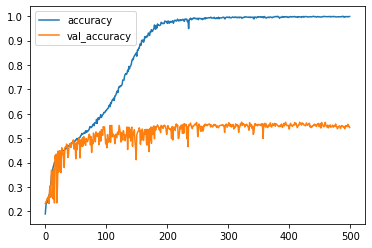

In [13]:
res[['accuracy','val_accuracy']].plot()

In [14]:
scores = model.evaluate(mels_test, one_hot[int(split):], verbose=1)
names = model.metrics_names

for i in range(len(scores)):
  print(f'{names[i]}: {scores[i]:.4f}')

24/24 [==============================] - 1s 17ms/step - loss: 4.0515 - accuracy: 0.5329
loss: 4.0515
accuracy: 0.5329


In [20]:
model.save('/content/gdrive/MyDrive/Colab Notebooks/Voice_CNN/6_2_2023_model')

In [34]:
model.load_weights('/content/gdrive/MyDrive/Colab Notebooks/Voice_CNN/6_2_2023_model_weights')